# Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors (i.e. "dense" vectors, as opposed to sparse vectors). Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 token in this case). So, word embeddings pack more information into far fewer dimensions.

One-hot word vectors:

- Sparse
- High-dimensional
- Hard-coded

Word embeddings:

- Dense
- Lower-dimensional
- Learned from data

There are two ways to obtain word embeddings:

- Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
- Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. These are called "pre-trained word embeddings".

## Learning word embeddings with the Embedding layer

Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points far away from each other, while related words would be closer). Even beyond mere distance, we may want specific directions in the embedding space to be meaningful.

It is thus reasonable to learn a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it even easier. It's just about learning the weights of a layer: the Embedding layer.

The Embedding layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

In [12]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

Let's apply this idea to the IMDB movie review sentiment prediction task:

In [13]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [14]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 56us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 1s 46us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 1s 46us/step - loss: 

## Using pre-trained word embeddings

Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a different problem.

We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a  Dense layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in Keras, we will start from scratch, by downloading the original text data.

## Download the IMDB data as raw text

In [15]:
import os

imdb_dir = 'Data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

## Tokenize the data

Let's vectorize the texts we collected, and prepare a training and validation split. We will merely be using the concepts we introduced earlier in this section.

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


## Pre-process the embeddings

In [17]:
glove_dir = 'Data/glove6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Let's build an embedding matrix that we will be able to load into an Embedding layer.

In [18]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

## Defining a model

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


## Loading the GloVe embeddings in the model

In [20]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

## Training and evaluating

In [21]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 1.6337 - acc: 0.5250 - val_loss: 0.7130 - val_acc: 0.5100
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7565 - acc: 0.5800 - val_loss: 0.6910 - val_acc: 0.5418
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5956 - acc: 0.6950 - val_loss: 1.1205 - val_acc: 0.4936
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5335 - acc: 0.7350 - val_loss: 0.7134 - val_acc: 0.5362
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4713 - acc: 0.8100 - val_loss: 0.7177 - val_acc: 0.5589
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1448 - acc: 0.9800 - val_loss: 1.3373 - val_acc: 0.4952
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2545 - acc: 0.8800 - val_loss: 1.3110 - val_acc: 0.4960
Epoch 8/10
200/200 [========

## Plot the performance

Let's plot its performance over time:

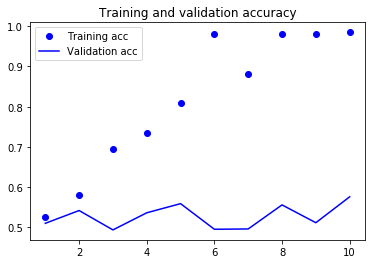

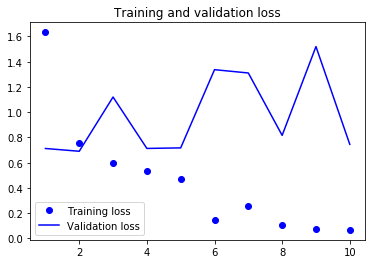

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for the same reason, but seems to reach high 50s.

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings when lots of data is available. 

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.6951 - acc: 0.4350 - val_loss: 0.6950 - val_acc: 0.5167
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5028 - a

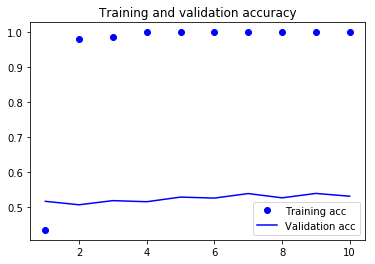

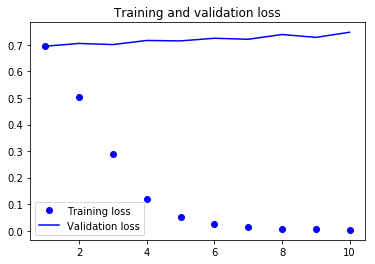

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate the model on the test data

Let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [25]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Let's load and evaluate the first model:

In [26]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 74us/step


[0.7448734271526337, 0.57604]

We get an appalling test accuracy. Working with just a handful of training samples is hard!